# Image Segmentation: Oxford Pets

In [2]:
import os
import re
import sys
import cv2
import PIL
import json
import math
import time
import random
import sklearn
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from skimage.transform import resize

import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

from tfr_builder_utils import load_image_rgb_data, normalize_image_channels

# from IPython import display
from IPython.display import clear_output

K.clear_session()
# tfds.disable_progress_bar()

physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Tensorflow version: ", tf.__version__)
print(physical_devices)

Tensorflow version:  2.1.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Download Oxford-IIIT Pets dataset

Segmentation masks are included

In [3]:
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
# !rm  images/*.mat

### Create TFRecords from downloaded files

In [4]:
def display(display_list):
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    
def extract_pets_data_info(path, subset=None):
    ids_temp = next(os.walk(path + "images"))[2]
    ids_1 = []
    for i in ids_temp:
        if i.endswith(".jpg"):
            ids_1.append(i)
            
    random.seed(2019)
    id_order = np.arange(len(ids_1))
    np.random.shuffle(id_order)
    
    ids = []
    for i in range(len(id_order)):
        ids.append(ids_1[np.int(id_order[i])])
        
    print("Number of images: " + str(len(ids)))
    
    image_data = []
            
    for n, id_ in enumerate(ids):
        print("\r Processing %s \ %s " % (n+1, len(ids)), end='')
        
        image_filename = path + "images/" + id_
        id_mask = id_[:-4] + ".png"
        mask_filename = path + "annotations/trimaps/" + id_mask
        
        # load image
        img = load_img(image_filename)
        x_img = img_to_array(img)
        x_img = x_img.squeeze()
        
        # load mask
        mask = img_to_array(load_img(mask_filename, color_mode = "grayscale"))
        mask = mask.astype(np.uint8)
        
        # get size info
        img_height = x_img.shape[0]
        img_width = x_img.shape[1]
        img_depth = x_img.shape[2]
        mask_depth = mask.shape[2]
        
        # parse file info
        label = re.findall(r'\d+', id_)
        label = label[0]
        pos_label = id_.find(label)
        text = id_[0:pos_label]
        text = text[:-1]
        text_encoded = int.from_bytes(text.encode(), 'little') # convertToNumber(text)

        # add to list of dicts
        image_dict = {
            "image_filename": image_filename,
            "mask_filename": mask_filename,
            "id": id_[:-4],
            "height": img_height,
            "width": img_width,
            "image_depth": img_depth,
            "mask_depth": mask_depth,
            "class_text_encoded": text_encoded,
            "class_label": int(label),
        }

        image_data.append(image_dict)
        
        if (subset is not None) and (n == subset-1):
            break
    
    return image_data

In [5]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    # If the value is an eager tensor BytesList won't unpack a string from an EagerTensor.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def serialize_example(image, mask, image_shape, mask_shape):
    feature = {
        'image': _bytes_feature(image),
        'segmentation':  _bytes_feature(mask),
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'image_depth': _int64_feature(image_shape[2]),
        'mask_depth': _int64_feature(mask_shape[2]),
    }
    #  Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


def write_tfrecord(tfrecord_dir, image_data, normalize=False, rgb_data=None):
    """To note: if images channels are normalized, then the images must be stores as float32. 
       This takes up way more space than uint8. """
    
    with tf.io.TFRecordWriter(tfrecord_dir) as writer:
        for n, datapoint in enumerate(image_data):
            print("\r Writing %s \ %s " % (n+1, len(image_data)), end='')

            # get image
            img = load_img(datapoint["image_filename"])
            img_array = img_to_array(img)
            if normalize:
                img_array = normalize_image_channels(img_array, rgb_data)
            
            img_bytes = tf.io.serialize_tensor(img_array)
            image_shape = img_array.shape

            # get mask
            mask = load_img(datapoint["mask_filename"], color_mode="grayscale")
            mask_array = img_to_array(mask)
            mask_array = mask_array.astype(np.uint8)
            mask_bytes = tf.io.serialize_tensor(mask_array)
            mask_shape = mask_array.shape

            example = serialize_example(img_bytes, mask_bytes, image_shape, mask_shape)
            writer.write(example)


        
def read_tfrecord(serialized_example):
    feature_description = {
        'image': tf.io.FixedLenFeature((), tf.string),
        'segmentation': tf.io.FixedLenFeature((), tf.string),
        'height': tf.io.FixedLenFeature((), tf.int64),
        'width': tf.io.FixedLenFeature((), tf.int64),
        'image_depth': tf.io.FixedLenFeature((), tf.int64),
        'mask_depth': tf.io.FixedLenFeature((), tf.int64),
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    
    image = tf.io.parse_tensor(example['image'], out_type = float)
    image_shape = [example['height'], example['width'], 3]
    image = tf.reshape(image, image_shape)
    
    mask = tf.io.parse_tensor(example['segmentation'], out_type = tf.uint8)
    mask_shape = [example['height'], example['width'], 1]
    mask = tf.reshape(mask, mask_shape)
    
    return image, mask


def get_dataset_from_tfrecord(tfrecord_dir):
    tfrecord_dataset = tf.data.TFRecordDataset(tfrecord_dir)
    parsed_dataset = tfrecord_dataset.map(read_tfrecord)
    return parsed_dataset

In [ ]:
path = "raw_data/"

image_info = extract_pets_data_info(path=path, subset=None)

In [ ]:
image_info[0]

In [ ]:
TRAIN_LENGTH = 5912
TEST_LENGTH = 1478

In [ ]:
train_info = image_info[0:TRAIN_LENGTH]
test_info = image_info[TRAIN_LENGTH:]

In [7]:
train_tfrecord_dir = 'train.tfrecords'
test_tfrecord_dir = 'test.tfrecords'

In [ ]:
write_tfrecord(tfrecord_dir=train_tfrecord_dir, image_data=train_info, normalize=False)

In [ ]:
write_tfrecord(tfrecord_dir=test_tfrecord_dir, image_data=test_info, normalize=False)

In [8]:
train_tfrecords_dataset = get_dataset_from_tfrecord(train_tfrecord_dir)
test_tfrecords_dataset = get_dataset_from_tfrecord(test_tfrecord_dir)

In [10]:
for i, (image, mask) in enumerate(train_tfrecords_dataset.take(4)):
    sample_image = image.numpy()
    sample_mask = mask.numpy()

In [11]:
print(sample_image.shape, sample_mask.shape)

(411, 500, 3) (411, 500, 1)


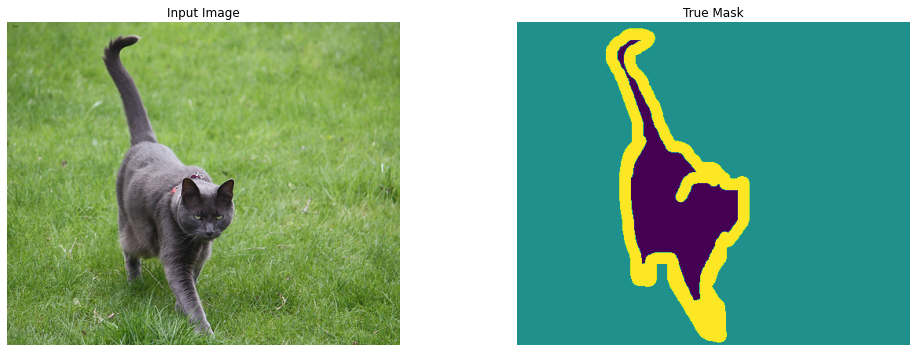

In [12]:
display([sample_image, sample_mask])